In [7]:
import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [73]:
from matplotlib.colors import ListedColormap

In [64]:
def raster2array(rasterfn):
    #print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

In [3]:
ecoCost = raster2array(os.path.abspath('01_Data500/fac_eco_onlySlope.tif'))
envCost = raster2array(os.path.abspath('01_Data500/fac_env.tif'))
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))
pubCost = raster2array(os.path.abspath('01_Data500/fac_pub.tif'))
allCost = (ecoCost+envCost+infCost+pubCost)/4

converting raster to array...
converting raster to array...
converting raster to array...
converting raster to array...


# Select DC and path_based_on

In [9]:
dc ='dc5'
path_based_on = 'all'
pathFile = os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'

In [42]:
factors = ['eco','env','inf','pub', 'all']

In [54]:
lines = ['dc1','dc2','dc3','dc4','dc5']

In [61]:
def line_path(path_based_on, dc):
    pathFl =  os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'
    return raster2array(pathFl)

In [74]:
colors = ['blue','green','firebrick', 'm','gray']
cmap = ListedColormap(colors)

# Line Length

In [99]:
def lineLength(lineArray):
    indicies = np.nonzero(lineArray)
    indicies_paired = np.stack((indicies[0],indicies[1]), axis=-1)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)*0.5
        disTot = disTot+dist
    return disTot

In [ ]:
allLineLenghts = []
for line in lines:
    for factor in factors:
        print(line, factor)
        lineLen = lineLength(line_path(path_based_on=factor, dc=line))
        allLineLenghts.append([line, factor, lineLen])
lengths = pd.DataFrame(allLineLenghts)
lengths.columns=['dc','basedOn','length']

dc1 eco


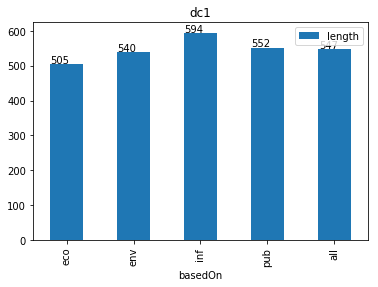

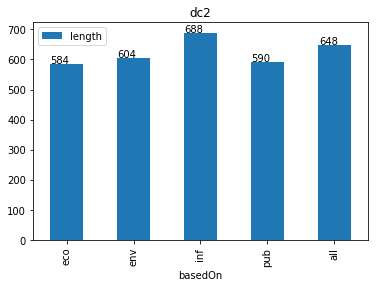

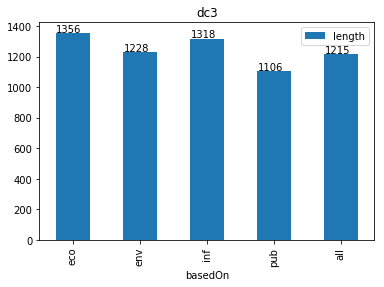

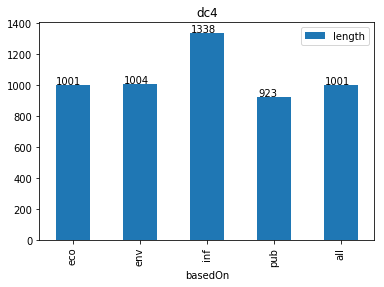

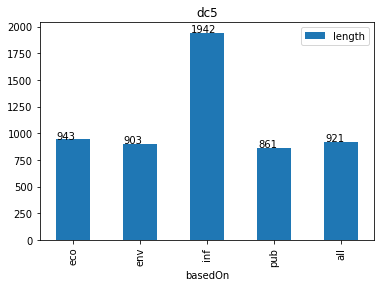

In [80]:
for line in lines:
    dcLine = lengths.loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

# Population Affected

In [95]:
popu = raster2array(os.path.abspath('01_Data500/population.tif'))

In [96]:
def peopleAffected(line, basedOn):
    path = line_path(path_based_on=basedOn, dc = line)
    return np.multiply(popu,path).sum()

In [97]:
peopleAffectedAll = []
for line in lines:
    for factor in factors:
        print(line, factor)
        peopleAff = peopleAffected(line, factor)
        peopleAffectedAll.append([line,factor, peopleAff])

peopleAff = pd.DataFrame(peopleAffectedAll)
peopleAff.columns=['dc','basedOn','peopleAffected']

dc1 eco
dc1 env
dc1 inf
dc1 pub
dc1 all
dc2 eco
dc2 env
dc2 inf
dc2 pub
dc2 all
dc3 eco
dc3 env
dc3 inf
dc3 pub
dc3 all
dc4 eco
dc4 env
dc4 inf
dc4 pub
dc4 all
dc5 eco
dc5 env
dc5 inf
dc5 pub
dc5 all


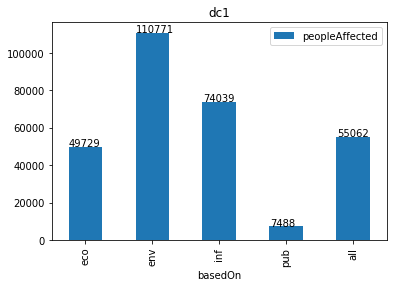

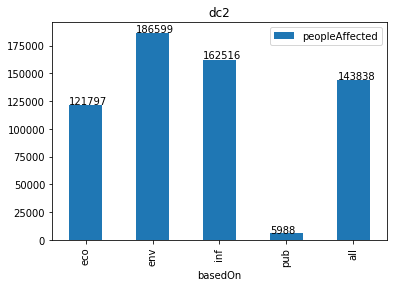

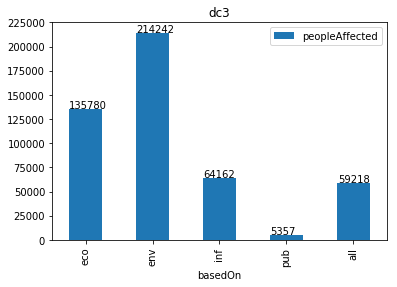

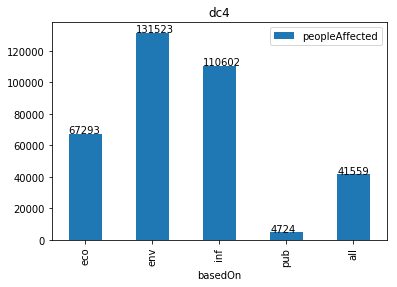

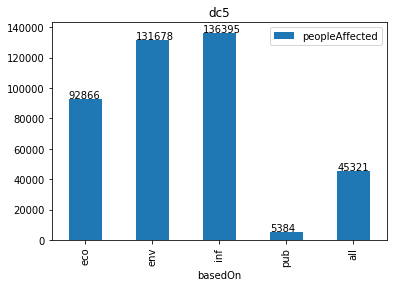

In [98]:
for line in lines:
    dcLine = peopleAff.loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

# Costs Based on renders 

In [90]:
def getCosts(path_based_on, dc):
    linePath = line_path(path_based_on=path_based_on, dc = dc)
    ecoCostLine = np.multiply(ecoCost, linePath).sum()
    envCostLine = np.multiply(envCost, linePath).sum()
    infCostLine = np.multiply(infCost, linePath).sum()
    pubCostLine = np.multiply(pubCost, linePath).sum()
    allCostLine = np.multiply(allCost, linePath).sum()
    return [ecoCostLine, envCostLine, infCostLine, pubCostLine, allCostLine]

In [89]:
def allCosts(line):
    cost = []
    for factor in factors:
        print(factor)
        facCost = getCosts(path_based_on=factor, dc=line)
        cost.append(facCost)
    allCost = pd.DataFrame(cost)
    allCost.columns=['eco','env','inf','pub','all']
    allCost['path_on'] = ['p_eco','p_env','p_inf','p_pub','p_all']
    return allCost.set_index('path_on')

In [91]:
def costGraph(data, title):
    data.plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.show()
    

def costDiffGraph(data, title):
    data.sub(data.xs('p_all'),axis=1).plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.show()
    
def costDiffNormGraph(data, title):
    data.sub(data.xs('p_all'), axis=1).div(data.xs('p_all'),axis=1).plot(kind='bar', cmap=cmap)
    plt.title(title)
    plt.show()

eco
env
inf
pub
all


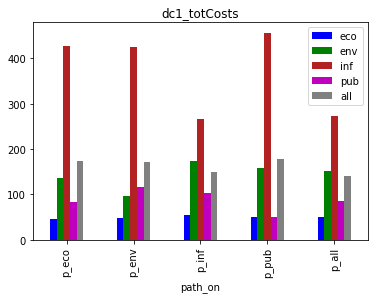

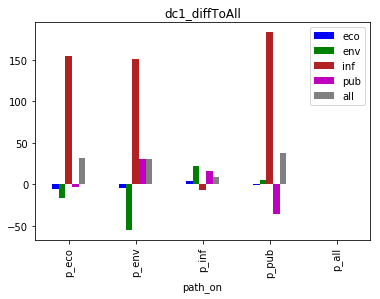

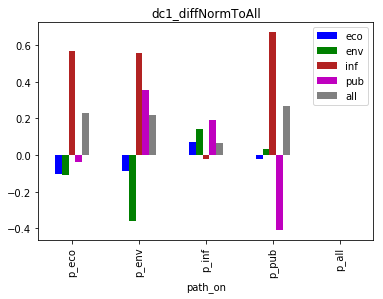

eco
env
inf
pub
all


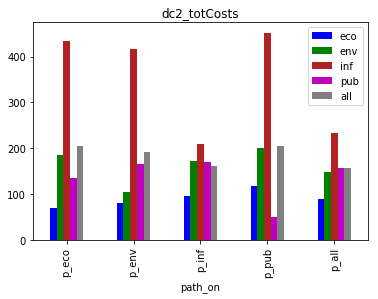

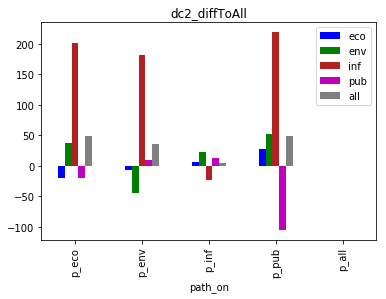

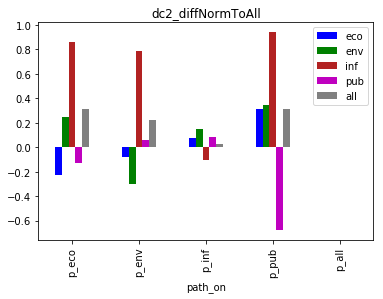

eco
env
inf
pub
all


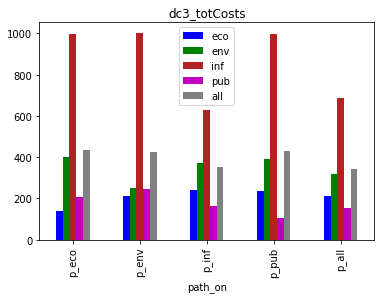

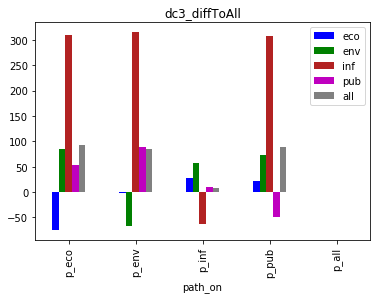

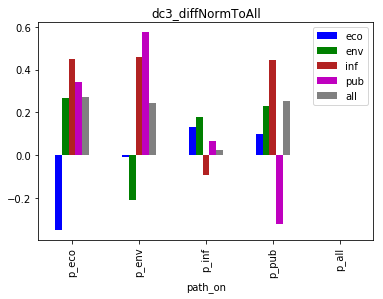

eco
env
inf
pub
all


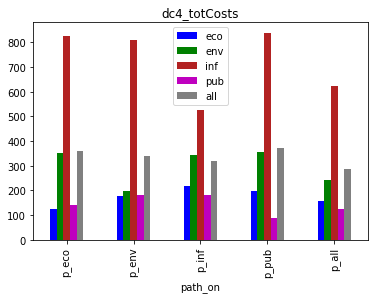

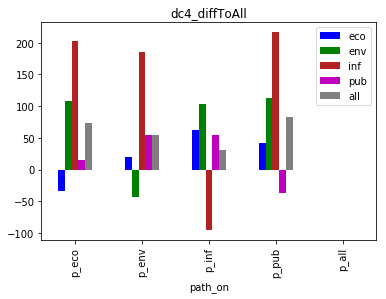

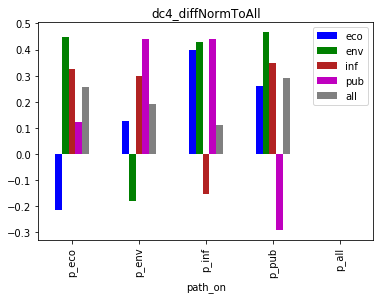

eco
env
inf
pub
all


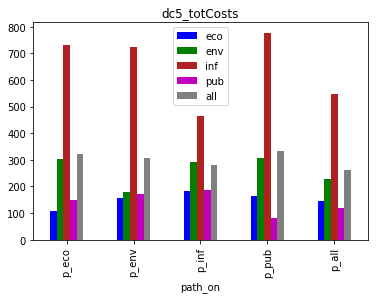

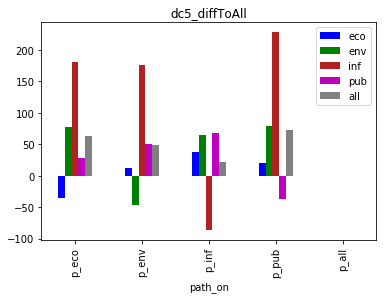

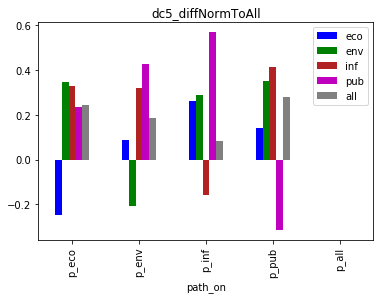

In [93]:
for line in lines:
    lineCosts = allCosts(line)
    costGraph(lineCosts, str(line+'_totCosts'))
    costDiffGraph(lineCosts, str(line+'_diffToAll'))
    costDiffNormGraph(lineCosts, str(line+'_diffNormToAll'))